# Part 4. Data cleaning

## Overview

The Data Cleaning phase occurs after Featurization. At this stage, we have the data as the tidy dataframe, but there are still:

* missing continuous values
* categorical values in need of transformation

In `sklearn` there are plenty of useful classes to address these problems. The only problem with them is that they do not keep the data in `pd.DataFrame` format, converting them to `numpy` arrays, thus losing the column names and making the debugging much harder.

`tg.common.ml.dft` (we will refer to it as `dft` for shortness) module offers a simple and elegant solution to this problem, wrapping the `sklearn` functionality and ensuring that the column names are preserved.

With `dft`, you define a single transformer, which is a normal `sklearn` transformer with `fit`, `fit_transform` and `transform` methods. This is a composite transformer that has the following structure:

```
DataFrameTransformer
  ↳ (has) List[DataFrameColumnsTransformer]
               ↳ (is) ContinousTransformer
                      ↳ (has) scaler
                              ↳ (is) sklearn.preprocessing.StandardScaler, etc
                      ↳ (has) 
                              ↳ (is) sklearn.preprocessing.SimpleImputer, etc
                      ↳ (has) missing_indicator
                              ↳ (is) sklearn.impute.MissingIndicator
                              ↳ (is) dft.MissingIndicatorWithReporting
               ↳ (is) CategoricalTransformer
                      ↳ (has) replacement_strategy
                              ↳ (is) MostPopularStrategy
                              ↳ (is) TopKPopularStrategy
                      ↳ (has) postprocessor
                              ↳ (is) OneHotEncoderForDataFrame
```

Since such data structures are quite cumbersome to write and read, `dft` also contains a `DataFrameTransformerFactory` class which can be used in the most widespread scenarios to specify `DataFrameTransformer` quickly. 

We will now demonstrate all these classes with the Titanic dataset.

In [1]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`Survived` is a label and should not go through the cleaning. 

`Pclass`, `SibSp`, `Parch` are integers, but in fact they are continous variables and we will convert them to the appropriate type.

In [2]:
for c in ['Pclass','SibSp','Parch']:
    df[c] = df[c].astype(float)

## Continuous transformation

The dataset contains the following continuous columns:

In [3]:
continuous_features = list(df.dtypes.loc[df.dtypes=='float64'].index)
continuous_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [4]:
df[continuous_features].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


All features require normalization, and `Age` requires imputation. Since this is a quite standard case, the default instance of `ContinousTransformer` will do:

In [5]:
from tg.common.ml import dft

tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features
    )
])
tdf = tr.fit_transform(df)
tdf.head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing
PassengerId,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False


We see new column, `Age_missing`, which is `True` is the `Age` value was missing for this row. For other columns, we don't see this, this is the default behaviour of the `MissingIndicator`

Let's check the distribution of `Age`:

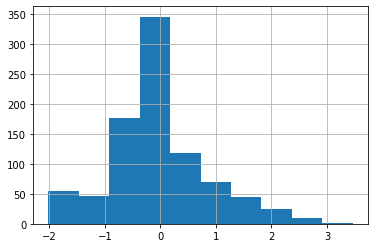

In [6]:
tdf.Age.hist()
pass

By the range of values it's easy to see that the `StandardScaler` was used. We can of course replace the scaler, as well as other components of the transformer

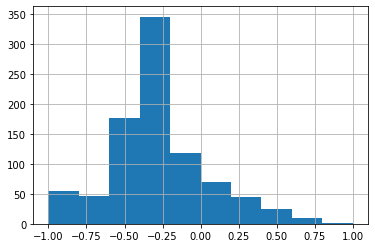

In [7]:
from sklearn.preprocessing import MinMaxScaler

tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        scaler = MinMaxScaler(feature_range=(-1,1))
    )
])
tr.fit_transform(df).Age.hist()
pass

Some notes on missing indicator. When the sklearn Missing indicator is used, the error is thrown when the column that did not happen to be None in training, does so in test:

In [8]:
import traceback

test_df = pd.DataFrame([dict(Survived=0, Age=30, SibSp=0, Fare=None)]).astype(float)
from sklearn.impute import MissingIndicator

tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        missing_indicator = MissingIndicator()
    )
])
tr.fit(df)
try:
    tr.transform(test_df)
except ValueError as exp:
    traceback.print_exc() #We catch the exception so the Notebook could proceed uninterrupted

Traceback (most recent call last):
  File "<ipython-input-1-5baf0da8dd5e>", line 14, in <module>
    tr.transform(test_df)
  File "/home/yura/Desktop/repos/boilerplate-service-ml/tg/common/ml/dft/architecture.py", line 49, in transform
    for res in transformer.transform(df):
  File "/home/yura/Desktop/repos/boilerplate-service-ml/tg/common/ml/dft/column_transformers.py", line 76, in transform
    missing = self.missing_indicator.transform(subdf)
  File "/home/yura/anaconda3/envs/bo/lib/python3.7/site-packages/sklearn/impute/_base.py", line 690, in transform
    "in fit.".format(features_diff_fit_trans))
ValueError: The features [4] have missing values in transform but have no missing values in fit.


This effect can be quite annoying if the column has `None` value in exceptionally low amount of fringe cases, so when doing random train/test split this value may become absent. To avoid that, `dft` improves the `sklearn` class:

In [9]:
tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        missing_indicator = dft.MissingIndicatorWithReporting() # This class is used by default
    )
])
tr.fit(df)
tr.transform(test_df)

,Pclass,Age,SibSp,Parch,Fare,Age_missing
0,0.0,0.020727,-0.474545,0.0,0.0,False


How do you know that something is wrong with this column? `dft` employs `TGWarningStorage` for non-critical errors:

In [10]:
from tg.common import TGWarningStorage

TGWarningStorage.get_report()

[{'_message': 'Missing column',
  'reporter': 'ContinousTransformer',
  'column': 'Pclass',
  '_count': 2},
 {'_message': 'Missing column',
  'reporter': 'ContinousTransformer',
  'column': 'Parch',
  '_count': 2},
 {'_message': 'Unexpected None',
  'reporter': 'MissingIndicatorWithReporting',
  'column': 'Pclass',
  '_count': 1},
 {'_message': 'Unexpected None',
  'reporter': 'MissingIndicatorWithReporting',
  'column': 'Parch',
  '_count': 1},
 {'_message': 'Unexpected None',
  'reporter': 'MissingIndicatorWithReporting',
  'column': 'Fare',
  '_count': 1}]

The recommendation is:

* If these None values are potentially critical for the model correctness, specify  `sklearn.impute.MissingIndicator`
* If they aren't, don't specify, so the default `dft.MissingIndicatorWithReporting` will be used. Check output warnings to monitor the issue.

## Categorical values

Categorical variables are processed by `CategoricalTransformer` with the following routine:

* Replace all the values with their string representation (for the sake of type consistancy)
* Also replace None with a provided string constant, `'NONE'` by default. After that, None is treated like normal value of categorical variable
* Apply replacement strategy: e.g. only keep N most popular values and ignore all else.
* Apply post-processing, e.g. One-Hot encoding

These are categorical variables of out dataset:

In [11]:
categorical_variables = list(df.dtypes.loc[df.dtypes!='float64'].index)
categorical_variables

['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [12]:
df[categorical_variables].head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,,
1,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [13]:
pd.Series({c: len(df[c].unique()) for c in categorical_variables}).sort_values()

Survived      2
Sex           2
Embarked      4
Cabin       148
Ticket      681
Name        891
dtype: int64

I will exclude Ticket and Name from features, because they are near to unique for each row so it does not make sense to include them. I will also exclude `Survived` because it is a label.

In [14]:
for c in ['Ticket','Name','Survived']:
    categorical_variables.remove(c)

In [15]:
df[categorical_variables].isnull().sum(axis=0)

Sex           0
Cabin       687
Embarked      2
dtype: int64

Categorical column transformer essentially does the following:

1. Converts all the values to string format. None/NaN is converted to a `NONE` string (parametrized in constructor)
2. Somehow deals with values: removes excessive values or values unseen during the training by replacing it with something.
3. Postprocesses the result with e.g. one-hot encoding or converting to indices if required by the model.

In [16]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=categorical_variables
    )
])
tdf = tr.fit_transform(df)
tdf.head()

,Sex,Cabin,Embarked
PassengerId,,,
1,male,NONE,S
2,female,C85,C
3,female,NONE,S
4,female,C123,S
5,male,NONE,S


Imagine we performed a train/test split so that `Embarked` was always not null in the training set.

In [17]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Embarked']
    )
])
tr.fit(df.loc[~df.Embarked.isnull()])
tr.transform(df.loc[df.Embarked.isnull()])

,Embarked
PassengerId,
62,S
830,S


We see it was converted to `S`. This is because by default, `MostPopular` strategy is used, and this strategy replaces the unseen values with the most popular ones. `S` is way more popular than others.

In [18]:
df.groupby(df.Embarked).size()

Embarked
C    168
Q     77
S    644
dtype: int64

For `Cabin` field, however, this strategy doesn't make much sense, because the number of different categories is too high. In one-hot encoding case, the number of columns will be enormous. So I recommend using `TopKPopularStrategy` in this case

In [19]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Cabin'],
        replacement_strategy= dft.TopKPopularStrategy(10,'OTHER')
    )
])
tdf = tr.fit_transform(df)
tdf.groupby('Cabin').size().sort_values(ascending=False)

Cabin
NONE           687
OTHER          175
G6               4
C23 C25 C27      4
B96 B98          4
F33              3
F2               3
E101             3
D                3
C22 C26          3
B5               2
dtype: int64

So we have 11 values, which is a constructor parameter 10 + 1 value for `'OTHER'` (you may replace `'OTHER'` with an arbitrary string constant in constructor). The top-popular category is `'None'`. Still, there are some cabins shared across several passenger, and that might allow us to predict the fate of other passengers in this cabings correctly - but still keeping this in control by limiting the amount of cabins.

After applying replacement strategy, we will _never_ have the values that we didn't have in a training set. This is crucial for sucessful run of the machine learning algorithm that are located down the stream.

All the messages about unexpected values are stored in `TgWarningStorage`

Finally, we can implement one-hot encoding, or other postprocessing, required for many models.

In [20]:
from sklearn.preprocessing import OneHotEncoder

tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Embarked','Cabin'],
        postprocessor=dft.OneHotEncoderForDataframe()
    )
])
tr.fit_transform(df).head()

,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_NONE,Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Combining transformers

You can combine different transformers for different columns.

The code below basically creates the transformer to feed Titanic Dataset into Logistic Regression

In [21]:
tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features
    ),
    dft.CategoricalTransformer(
        columns= ['Sex','Embarked'],
        postprocessor=dft.OneHotEncoderForDataframe()
    ),
    dft.CategoricalTransformer(
        columns=['Cabin'],
        replacement_strategy=dft.TopKPopularStrategy(10,'OTHER'),
        postprocessor=dft.OneHotEncoderForDataframe()
    )
])
tr.fit_transform(df).head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_female,Sex_male,Embarked_C,Embarked_NONE,...,Cabin_B96 B98,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_D,Cabin_E101,Cabin_F2,Cabin_F33,Cabin_G6,Cabin_NONE,Cabin_OTHER
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Transformer factories

There are two problems with the transformers. The first is subjective: the initialization code for a large transformer sets is ugly. The second is more problematic: in order to build the transformers, you usually need to see the data first: for instance, to decide, which categorical columns should be processed with default replacement strategy, and which should be processed with `TopKReplacementStrategy`.

Both of these problems are solved by DataFrameTransformerFactory. This is the class is an `sklearn` transformer. When `fit` is called, it creates the DataFrameTransformer according to its setting, and fits this transformer. When transforming, it just passes the data to the transformer that should be created ealier.

The following code is creating the factory for the Titanic dataset:


In [22]:
from functools import partial

tfac = (dft.DataFrameTransformerFactory()
 .with_feature_block_list(['Survived','Name','Ticket'])
 .on_continuous(dft.ContinousTransformer)
 .on_categorical(partial(
     dft.CategoricalTransformer, 
     postprocessor=dft.OneHotEncoderForDataframe()))
 .on_rich_category(10, partial(
     dft.CategoricalTransformer, 
     postprocessor=dft.OneHotEncoderForDataframe(), 
     replacement_strategy = dft.TopKPopularStrategy(10,'OTHER')
)))

tfac.fit_transform(df).head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Cabin_B5,Cabin_B96 B98,Cabin_C22 C26,Cabin_C23 C25 C27,...,Cabin_F33,Cabin_G6,Cabin_NONE,Cabin_OTHER,Sex_female,Sex_male,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


`partial` is used here for the following reason. `on_continuous`, `on_categorical` etc methods receive the function, that accepts the list of column names and creates a `DataFrameColumnTransformer` for them. Normally, we would write something like:

```
on_categorical(
    lambda features: dft.CategoricalTransformer(features, postprocessor=dft.OneHotEncoderForDataframe())
```

But the `DataFrameTransformerFactory` object is typically to be delivered to the remote server, and for this it has to be serializable. Unfortunately, lambdas is Python are not serializable. Therefore, we need to replace them, and `partial` is a good tool.